In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold as SK
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score



train = pd.read_csv('../input/tabular-playground-series-dec-2021/train.csv')

test = pd.read_csv('../input/tabular-playground-series-dec-2021/test.csv')

submission = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')


2025-08-18 19:29:44.722842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755545384.735588       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755545384.739479       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 19:29:44.754785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def reduce_mean_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] =='int':
                if c_min > np.iinfo(np.int8).min and c_max  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max  np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max  np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min> np.iinfo(np.int64).min and c_max  np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max  np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose:
        print('Memory usage is decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem)/ start_mem))
    
    return df


SyntaxError: invalid syntax (2653595915.py, line 13)

In [4]:
train = reduce_mean_usage(train)
test = reduce_mean_usage(test)


NameError: name 'reduce_mean_usage' is not defined

In [5]:
train = train.sample(frac=1).reset_index(drop=True)

train_x = train.drop(['Id','Cover_Type'],axis=1)

test_x = test.drop(['Id'],axis=1)

train_y = train['Cover_Type']

train


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,909201,2907,309,11,398,58,535,224,227,118,...,0,0,0,0,0,0,0,0,0,2
1,474538,3030,84,29,242,75,3478,213,226,81,...,0,0,0,0,0,0,0,0,0,2
2,232727,3296,127,14,333,85,2960,229,230,154,...,0,0,0,0,0,0,0,0,0,1
3,2264271,2688,310,8,101,53,3150,251,243,112,...,0,0,0,0,0,0,0,0,0,2
4,969619,3320,309,2,112,39,1784,234,238,168,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599995,2066905,2734,297,14,297,73,2977,235,227,68,...,0,0,0,0,0,0,0,0,0,2
3599996,2391741,3182,282,6,26,104,1767,221,223,122,...,0,0,0,0,0,0,1,1,0,1
3599997,3676151,3322,74,9,58,261,2673,220,239,200,...,1,0,0,0,0,0,0,0,0,1
3599998,611903,2938,278,21,81,167,1594,202,221,135,...,0,0,0,0,0,0,0,0,0,2


In [6]:
train_x.isnull().sum()


Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


In [7]:
train_y.isnull().sum()


0

In [8]:
train_y.value_counts()


Cover_Type
2    2036254
1    1320866
3     176184
7      56125
6      10237
4        333
5          1
Name: count, dtype: int64

In [9]:
drop_5_index = train_y[train_y == 5].index[0]

train_x = train_x.drop([drop_5_index],axis=0).reset_index().drop(['index'],axis=1)
train_y = train_y.drop([drop_5_index],axis=0).reset_index().drop(['index'],axis=1)


In [10]:
train_x.describe()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,...,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06,3.599999e+06
mean,2.980147e+03,1.515727e+02,1.510049e+01,2.712762e+02,5.166788e+01,1.766483e+03,2.118390e+02,2.210576e+02,1.408136e+02,1.581519e+03,...,2.750584e-02,3.746251e-02,3.785973e-02,1.201639e-02,1.604195e-02,1.068556e-02,1.219861e-02,4.074918e-02,3.924223e-02,3.158945e-02
std,2.890441e+02,1.099497e+02,8.546343e+00,2.265100e+02,6.822503e+01,1.315661e+03,3.075498e+01,2.223373e+01,4.367894e+01,1.127623e+03,...,1.635521e-01,1.898923e-01,1.908570e-01,1.089587e-01,1.256368e-01,1.028172e-01,1.097716e-01,1.977086e-01,1.941708e-01,1.749045e-01
min,1.773000e+03,-3.300000e+01,-3.000000e+00,-8.200000e+01,-3.170000e+02,-2.870000e+02,-4.000000e+00,4.900000e+01,-5.300000e+01,-2.770000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.760000e+03,6.000000e+01,9.000000e+00,1.100000e+02,4.000000e+00,8.220000e+02,1.980000e+02,2.100000e+02,1.150000e+02,7.810000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.966000e+03,1.230000e+02,1.400000e+01,2.130000e+02,3.100000e+01,1.436000e+03,2.180000e+02,2.240000e+02,1.420000e+02,1.361000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.217000e+03,2.470000e+02,2.000000e+01,3.610000e+02,7.800000e+01,2.365000e+03,2.330000e+02,2.370000e+02,1.690000e+02,2.084000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.383000e+03,4.050000e+02,6.400000e+01,1.602000e+03,6.320000e+02,7.666000e+03,2.970000e+02,2.790000e+02,2.720000e+02,8.075000e+03,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [11]:
train_y.value_counts()


Cover_Type
2             2036254
1             1320866
3              176184
7               56125
6               10237
4                 333
Name: count, dtype: int64

In [12]:
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train_x)
train_df = pd.DataFrame(train_df)
train_df.columns = train_x.columns
train_df


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.434483,0.780822,0.208955,0.285036,0.395153,0.103357,0.757475,0.773913,0.526154,0.383381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.481609,0.267123,0.477612,0.192399,0.413066,0.473406,0.720930,0.769565,0.412308,0.250838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.583525,0.365297,0.253731,0.246437,0.423604,0.408274,0.774086,0.786957,0.636923,0.124641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.350575,0.783105,0.164179,0.108670,0.389884,0.432164,0.847176,0.843478,0.507692,0.386734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.592720,0.780822,0.074627,0.115202,0.375132,0.260405,0.790698,0.821739,0.680000,0.181034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599994,0.368199,0.753425,0.253731,0.225059,0.410959,0.410411,0.794020,0.773913,0.372308,0.194804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3599995,0.539847,0.719178,0.134328,0.064133,0.443625,0.258267,0.747508,0.756522,0.538462,0.613147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3599996,0.593487,0.244292,0.179104,0.083135,0.609062,0.372187,0.744186,0.826087,0.778462,0.127874,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3599997,0.446360,0.710046,0.358209,0.096793,0.510011,0.236515,0.684385,0.747826,0.578462,0.167265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
test_df = pd.DataFrame(scaler.transform(test_x))
test_df.columns = test_x.columns
test_df


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.521839,0.285388,0.537313,0.260095,0.415174,0.218408,0.774086,0.782609,0.738462,0.226054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.490038,0.301370,0.343284,0.248812,0.552160,0.114674,0.661130,0.617391,0.190769,0.307711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.611111,0.783105,0.223881,0.120546,0.492097,0.230605,0.750831,0.813043,0.489231,0.073276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.523755,0.244292,0.194030,0.089667,0.348788,0.079467,0.710963,0.904348,0.843077,0.103568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.654023,0.438356,0.253731,0.320071,0.340358,0.207972,0.461794,0.839130,0.873846,0.139128,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0.436015,0.479452,0.104478,0.140736,0.340358,0.205331,0.800664,0.473913,0.664615,0.176125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399996,0.432950,0.079909,0.388060,0.104513,0.585880,0.346284,0.800664,0.782609,0.507692,0.113266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
399997,0.502682,0.333333,0.253731,0.164489,0.337197,0.303156,0.717608,0.695652,0.646154,0.562979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399998,0.583525,0.214612,0.238806,0.287411,0.329821,0.047026,0.823920,0.469565,0.556923,0.385057,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
train_df.columns


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [15]:
train_non_dummy, train_dummy = train_df.columns[:10], train_df.columns[10:]

train_df_dummy = train_df[train_dummy]
train_df_non_dummy = train_df[train_non_dummy]


In [16]:
test_df_dummy = test_df[train_dummy]
test_df_non_dummy = test_df[train_non_dummy]


In [17]:
INPUT = tf.keras.layers.Input(shape = train_df_non_dummy.shape[1:], name = 'Input')
INPUT_dummy = tf.keras.layers.Input(shape = train_df_dummy.shape[1:], name = 'Input_Dummy')

dense1 = tf.keras.layers.Dense(300, activation='elu',  kernel_initializer = 'he_normal', name = 'Dense1')(INPUT)
dense2 = tf.keras.layers.Dense(300, activation='elu',  kernel_initializer = 'he_normal',name = 'Dense2')(dense1)
dense3 = tf.keras.layers.Dense(300, activation='elu',  kernel_initializer = 'he_normal',name = 'Dense3')(dense2)
dense4 = tf.keras.layers.Dense(300, activation='elu',  kernel_initializer = 'he_normal',name = 'Dense4')(dense3)
dense5 = tf.keras.layers.Dense(300, activation='elu',  kernel_initializer = 'he_normal',name = 'Dense5')(dense4)
dense6 = tf.keras.layers.Dense(300, activation='elu',  kernel_initializer = 'he_normal',name = 'Dense6')(dense5)
dense_dropout = tf.keras.layers.Dropout(0.5, name = 'Dropout')(dense6)

dummy_dense1 = tf.keras.layers.Dense(200, activation = 'elu', kernel_initializer = 'he_normal',name = 'Dummy_Dense1')(INPUT_dummy)
dummy_dense2 = tf.keras.layers.Dense(200, activation = 'elu', kernel_initializer = 'he_normal',name = 'Dummy_Dense2')(dummy_dense1)
dummy_dense3 = tf.keras.layers.Dense(200, activation = 'elu', kernel_initializer = 'he_normal',name = 'Dummy_Dense3')(dummy_dense2)
dummy_dense4 = tf.keras.layers.Dense(200, activation = 'elu', kernel_initializer = 'he_normal',name = 'Dummy_Dense4')(dummy_dense3)
dummy_dense5 = tf.keras.layers.Dense(200, activation = 'elu', kernel_initializer = 'he_normal',name = 'Dummy_Dense5')(dummy_dense4)
dummy_dense6 = tf.keras.layers.Dense(200, activation = 'elu', kernel_initializer = 'he_normal',name = 'Dummy_Dense6')(dummy_dense5)
dummy_dense_dropout = tf.keras.layers.Dropout(0.5, name = 'Dummy_Dropout')(dummy_dense6)

connect = tf.keras.layers.Concatenate(axis=1, name='Connection')([dense_dropout, dummy_dense_dropout])

connect_dense1 = tf.keras.layers.Dense(100, activation = 'elu', kernel_initializer = 'he_normal',name = 'Connect_Dense1')(connect)
connect_dense2 = tf.keras.layers.Dense(50, activation = 'elu', kernel_initializer = 'he_normal',name = 'Connect_Dense2')(connect_dense1)
connect_dense3 = tf.keras.layers.Dense(25, activation = 'elu', kernel_initializer = 'he_normal',name = 'Connect_Dense3')(connect_dense2)

OUTPUT = tf.keras.layers.Dense(6, activation = 'softmax', name = 'Output')(connect_dense3)

model = tf.keras.Model(inputs = [INPUT, INPUT_dummy], outputs = [OUTPUT], name = 'pythonash_model')


2025-08-18 19:30:08.042053: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
model.summary()


Model: "pythonash_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 10)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Dummy         │ (None, 44)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 300)       │      3,300 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dummy_Dense1        │ (None, 200)       │      9,000 │ Input_Dummy[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense2 (Dense)      │ (None, 300)       │     90,300 │ Dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dummy_Dense2        │ (None, 200)       │     40,200 │ Dummy_Dense1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense3 (Dense)      │ (None, 300)       │     90,300 │ Dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dummy_Dense3        │ (None, 200)       │     40,200 │ Dummy_Dense2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense4 (Dense)      │ (None, 300)       │     90,300 │ Dense3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dummy_Dense4        │ (None, 200)       │     40,200 │ Dummy_Dense3[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense5 (Dense)      │ (None, 300)       │     90,300 │ Dense4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dummy_Dense5        │ (None, 200)       │     40,200 │ Dummy_Dense4[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense6 (Dense)      │ (None, 300)       │     90,300 │ Dense5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dummy_Dense6        │ (None, 200)       │     40,200 │ Dummy_Dense5[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout (Dropout)   │ (None, 300)       │          0 │ Dense6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dummy_Dropout       │ (None, 200)       │          0 │ Dummy_Dense6[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Connection          │ (None, 500)       │          0 │ Dropout[0][0],    │
│ (Concatenate)       │                   │            │ Dummy_Dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Connect_Dense1      │ (None, 100)       │     50,100 │ Connection[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Connect_Dense2      │ (None, 50)        │      5,050 │ Connect_Dense1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 721,381 (2.75 MB)

 Trainable params: 721,381 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

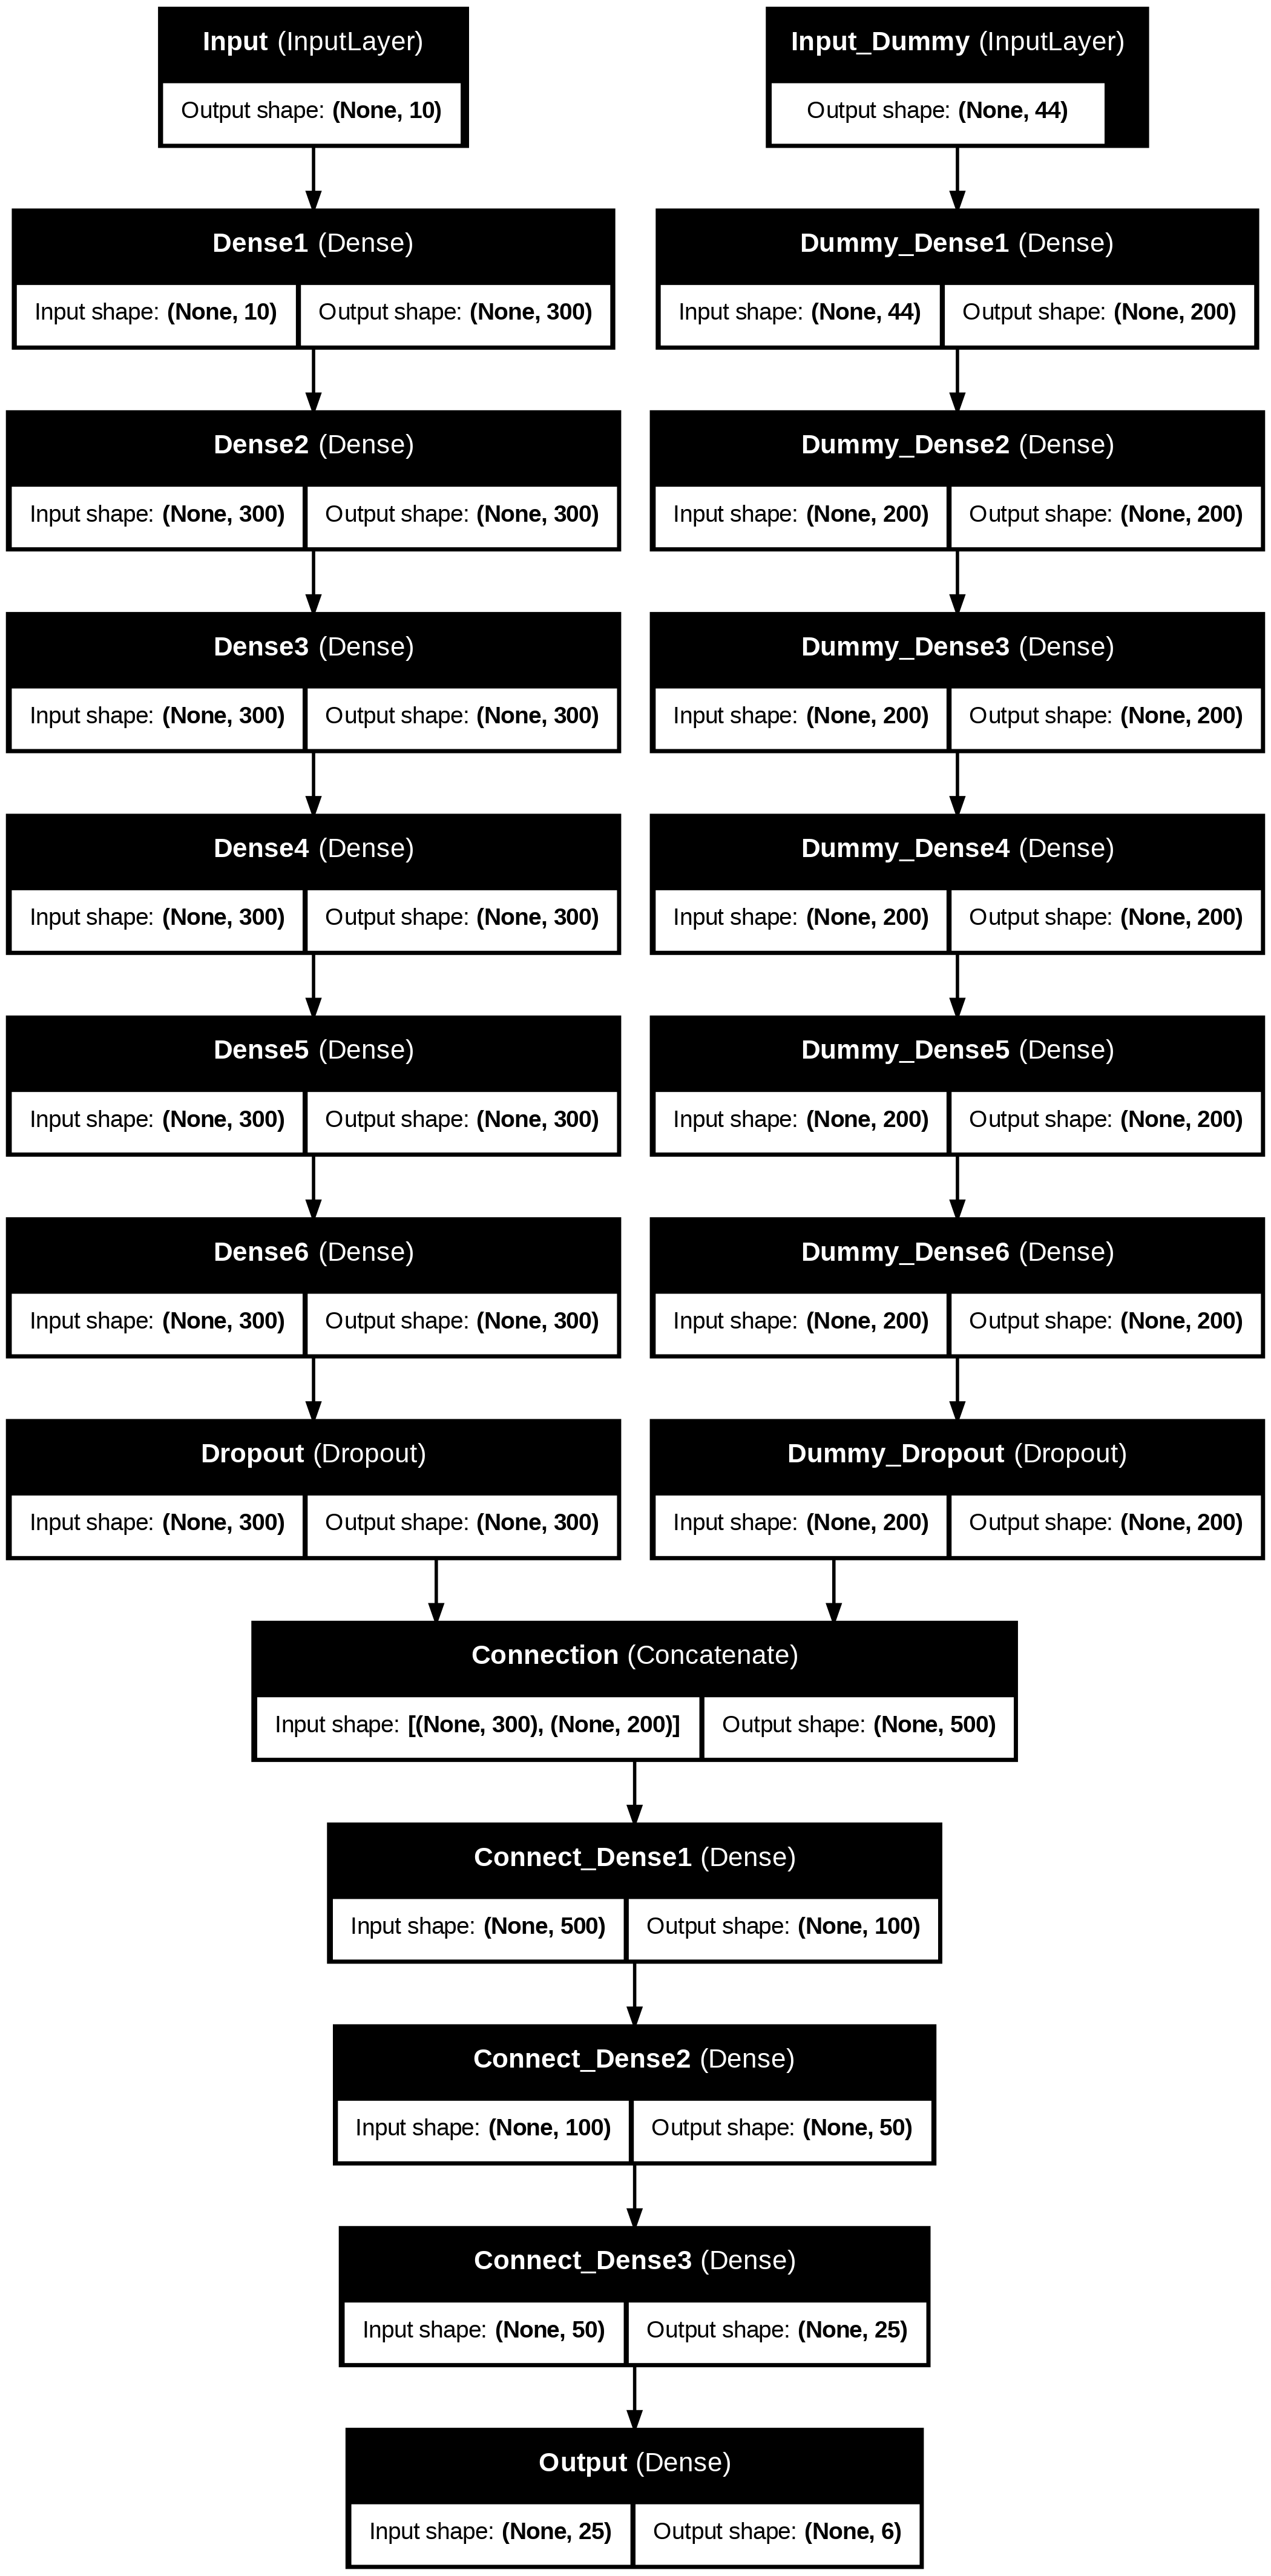

In [19]:
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names=True, rankdir='TB')


In [20]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.002,
    decay_steps=5000,
    decay_rate=0.99
)
opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
epoch_number = 20
check_pt = tf.keras.callbacks.ModelCheckpoint('pythonash_model.h5', save_best_only = True, verbose = 2)


In [21]:
train=[]
test=[]
train_x=[]
test_x=[]

train_df=[]
test_df=[]


In [22]:
Encoder = LabelEncoder()

y_encoded = Encoder.fit_transform(train_y)
train_y = []
y_encoded


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 0, ..., 0, 1, 1])

In [23]:
y_encoded


array([1, 1, 0, ..., 0, 1, 1])

In [24]:
model.compile(loss ='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
model.fit(
x= [train_df_non_dummy, train_df_dummy], y = y_encoded, validation_split = 0.1 , batch_size = 1000, validation_batch_size = 1000,
callbacks = [check_pt], verbose =2, workers = 3, epochs = epoch_number)


TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'workers'

In [25]:
best_model = tf.keras.models.load_model('pythonash_model.h5')
result = best_model.predict([test_df_non_dummy, test_df_dummy])
result = Encoder.inverse_transform(np.argmax(result,axis=1))
final_result = pd.DataFrame(result)
final_result.columns =['Cover_Type']
final_result


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'pythonash_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [26]:
submission['Cover_Type'] = final_result['Cover_Type']

submission.to_csv('./submission.csv', index=False)

submission


NameError: name 'final_result' is not defined